In [3]:
# some imports
import os
import numpy as np
np.random.seed(seed=1)
import pickle
from glob import glob
%matplotlib notebook
from matplotlib import pyplot as plt
from natsort import natsorted
import keras
from keras.optimizers import Adam

# import custom functions and viewing tools
from VisTools import multi_slice_viewer0, mask_viewer0
from KerasModel import BlockModel, dice_coef_loss, CalcVolumes

ModuleNotFoundError: No module named 'keras'

In [2]:
#~# some parameters to set for inference #~#
# model version to use
model_version = 5
model_weights_path = os.path.join(os.getcwd(),
                                  'BestModelWeights_dataset2_v{:02d}.h5'.format(model_version))
# set data directories
dataset_dir = os.path.join('/home','bashirmllab','dataset2')
subdirs = ['opposed','SSFSE','t1nfs']
data_dirs = [os.path.join(dataset_dir,d+'_output') for d in subdirs]

NameError: name 'os' is not defined

In [3]:
with open('test_input_files_v{:02d}.pkl'.format(model_version), 'rb') as f:
    test_input_files = natsorted(pickle.load(f))
with open('test_target_files_v{:02d}.pkl'.format(model_version), 'rb') as f:
    test_target_files = natsorted(pickle.load(f))

In [4]:
# Find unique sequence names based on file 
sequences = [os.path.split(os.path.dirname(f))[1] for f in test_input_files]
unq_sequences = list(set(sequences))
grouped_input_files = [[f for f in test_input_files if u_s in f] for u_s in unq_sequences]
grouped_target_files = [[f for f in test_target_files if u_s in f] for u_s in unq_sequences]

In [5]:
print('Loading data...')
inputs = [np.concatenate([np.load(f) for f in g])[...,np.newaxis] for g in grouped_input_files]
targets = [np.concatenate([np.load(f) for f in g])[...,np.newaxis] for g in grouped_target_files]
print("Data loaded")

Loading data...
Data loaded


In [6]:
# prepare model
model = BlockModel(inputs[0].shape,filt_num=16,numBlocks=4)
model.compile(optimizer=Adam(), loss=dice_coef_loss)

# load best weights
model.load_weights(model_weights_path)
# evaluate on test data
print('Evaluating data...')
for i,d in enumerate(unq_sequences):
    score = model.evaluate(inputs[i],targets[i],verbose=1)
    print("Test Dice score on {} is {:.03f}".format(d,1-score))

Evaluating data...
854/854 [==============================] - 16s 19ms/step
Test Dice score on SSFSE_output is 0.946
1056/1056 [==============================] - 15s 14ms/step
Test Dice score on t1nfs_output is 0.853
205/205 [==============================] - 4s 17ms/step
Test Dice score on opposed_output is 0.906


Generating masks...


<IPython.core.display.Javascript object>


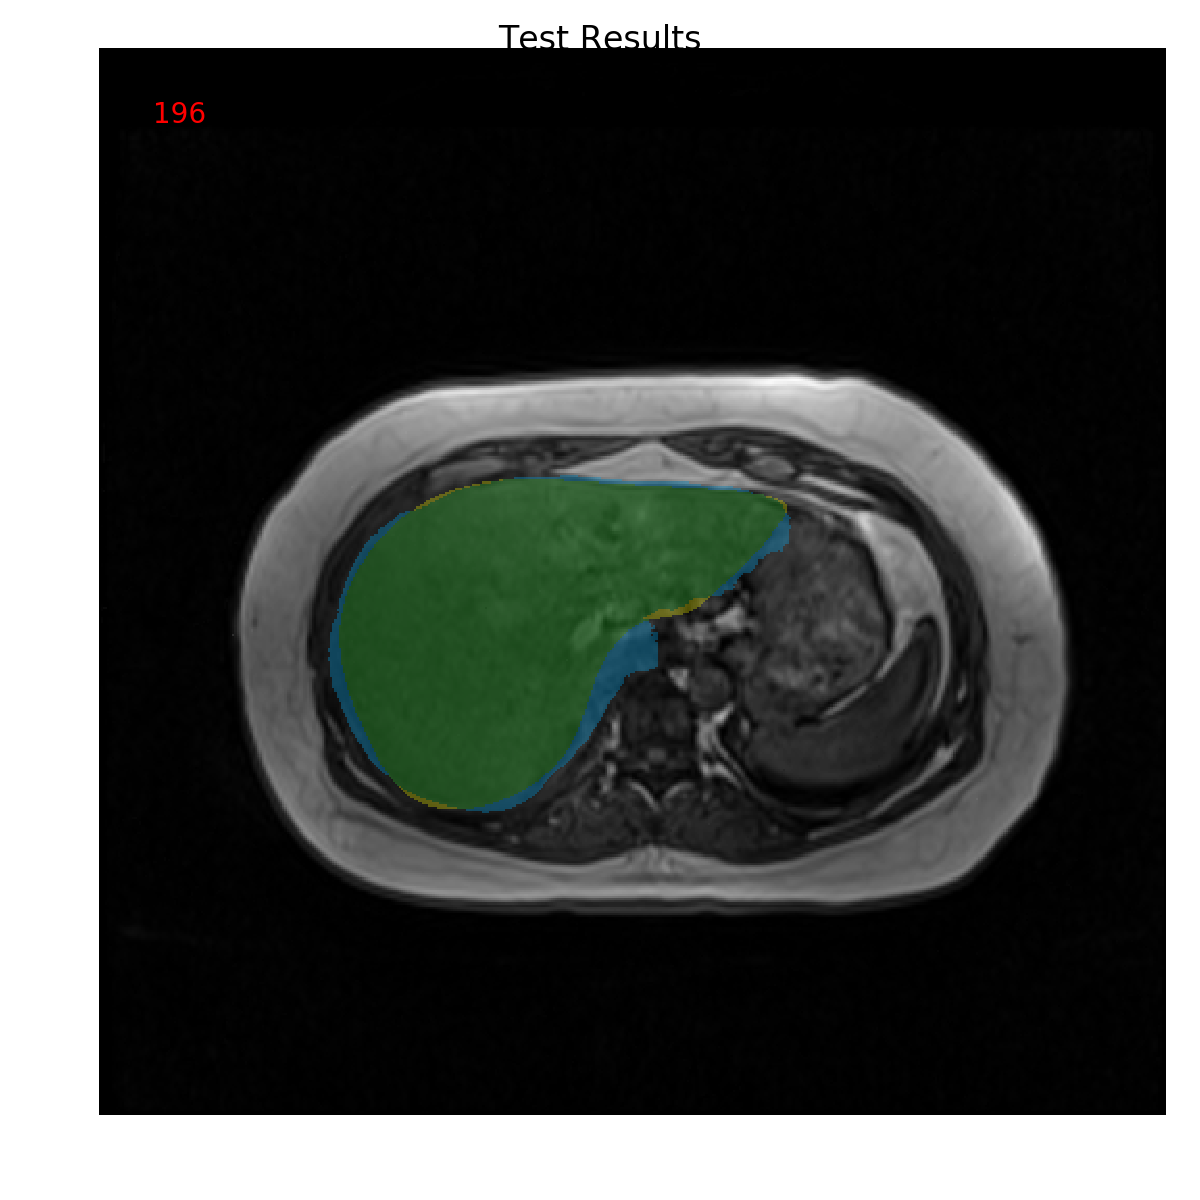

In [8]:
# display some results
print('Generating masks...')
seq_num = 1
output = model.predict(inputs[seq_num],batch_size=16)
mask_viewer0(inputs[seq_num][...,0],targets[seq_num][...,0],output[...,0],name='Test Results')
plt.show()

In [ ]:
# set voxel dimensions (in cm)
sx = 1
sy = 1
sz = 1
vox_vol = sx*sy*sz
# loop over different sequence types
for sequence in all_inputs:
    # loop over all subjects
    results = []
    for inp_file,targ_file in zip(all_inputs,all_targets):
        # run function to perform calculations
        calc,truth = CalcVolumes(inp_file,targ_file,vox_vol,model)
        results.append((calc,truth))
# display results
print('---------------------------------------')
print(inp_file[-30:])
print("The calculated volume is {:.02f} voxels".format(calc))
print("The actual volume is {:.02f} voxels".format(truth))

In [1]:
x = [r[1] for r in results]
y = [r[0] for r in results]
plt.figure()
plt.plot(x,y,'ro')
plt.plot(np.arange(0,np.max(x)),np.arange(0,np.max(x)),'k--')
plt.xlim([0,np.max(x)])
plt.ylim([0,np.max(y)])
plt.ylabel('Calculated Volume (cc)')
plt.xlabel('Actual Volume (cc)')
plt.title("Correlation of Actual and Predicted Liver Volumes of Test Subjects")
plt.show()
cc = np.corrcoef(x,y)[0,1]
print('Correlation coefficient is {:.03f}'.format(cc))

NameError: name 'results' is not defined